In [1]:
import base64
import json
import os
os.environ['USE_PYGEOS'] = '0'
import requests

from pprint import pprint

from botocore.exceptions import ClientError


from FH_Hydrosat import FH_Hydrosat
import folium
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pystac
from pystac_client import Client
from pyproj.crs import CRS
import rioxarray as rxr
from shapely.geometry import box, mapping, Point, Polygon
import rasterio as rio
import xarray as xr

In [2]:
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

<AxesSubplot:>

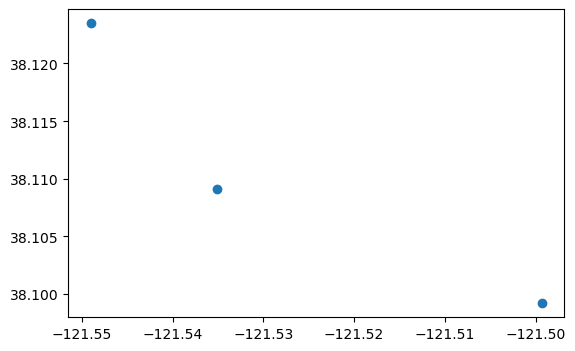

In [3]:
insitu_points = {
    'Rice': [38.1235, -121.5490],
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

insitu_df = pd.DataFrame.from_dict(insitu_points,
                                   orient='index',
                                   columns=['lat', 'lon'])
insitu_gdf = gpd.GeoDataFrame(
    insitu_df, 
    geometry=gpd.points_from_xy(insitu_df.lon, insitu_df.lat),
    crs=CRS.from_epsg(4326))
insitu_gdf.plot()

In [4]:
# Create aoi geodataframe by buffering points by 100m
aoi_gdf = gpd.GeoDataFrame(
    geometry=[box(*insitu_gdf.total_bounds)], 
    crs=CRS.from_epsg(4326))
raster_crs = CRS.from_epsg(32610)
buffer_dist = 1000
aoi_gdf = aoi_gdf.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer

In [5]:
# Map the bounding box and points
m = folium.Map(
    location=[insitu_gdf.geometry.y.mean(), insitu_gdf.geometry.x.mean()],
    zoom_start=14, tiles='Stamen Terrain')

sim_geo = aoi_gdf.to_crs(CRS.from_epsg(4326)).simplify(tolerance=0.001)
geo_j = gpd.GeoSeries(sim_geo).to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'red'})
geo_j.add_to(m)

for point in insitu_points:
    lat = insitu_points.get(point)[0]
    lon = insitu_points.get(point)[1]

    folium.Marker(location=[lat, lon]).add_to(m)

m

In [6]:
collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
start_date = "2017-05-01T00:00:00Z"
end_date = "2022-10-30T00:00:00Z"

search = catalog.search(
    collections = collections,
    intersects = box(*aoi_gdf.to_crs(CRS.from_epsg(4326)).total_bounds),
    datetime = [start_date, end_date],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
items = list(search.get_all_items()) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time
len(items)

284

In [7]:
mgrs_tiles = []
for i in items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
print(f'number of tiles in query: {len(set(mgrs_tiles))}, {set(mgrs_tiles)}')

# if there is more than one tile, uncomment and execute this next line to choose the MGRS tile you are interested in
# items = [i for i in items if mgrs_tiles[0] in i.id]

number of tiles in query: 1, {'10SFH'}


In [8]:
from FH_Hydrosat import FH_Hydrosat
res = FH_Hydrosat(items[:25])
stacked_res = res.stack()
stacked_res.ds.sortby('time')

<xarray.DataArray (time: 25, band: 1, y: 5490, x: 5490)>
dask.array<concatenate, shape=(25, 1, 5490, 5490), dtype=float32, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 4.3e+06 4.3e+06 4.3e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int32 0
  * time         (time) object 2022-01-03T18:46:19.542715+00:00 ... 2022-01-2...
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0

In [9]:
ds = stacked_res.ds.sortby('time')

In [10]:
from FH_Hydrosat import FH_StackedDataset

# clip the raster dataset and cast to a class with slightly more functions
clipped = FH_StackedDataset(ds.rio.clip(aoi_gdf.geometry))
ds_clip = clipped.ds

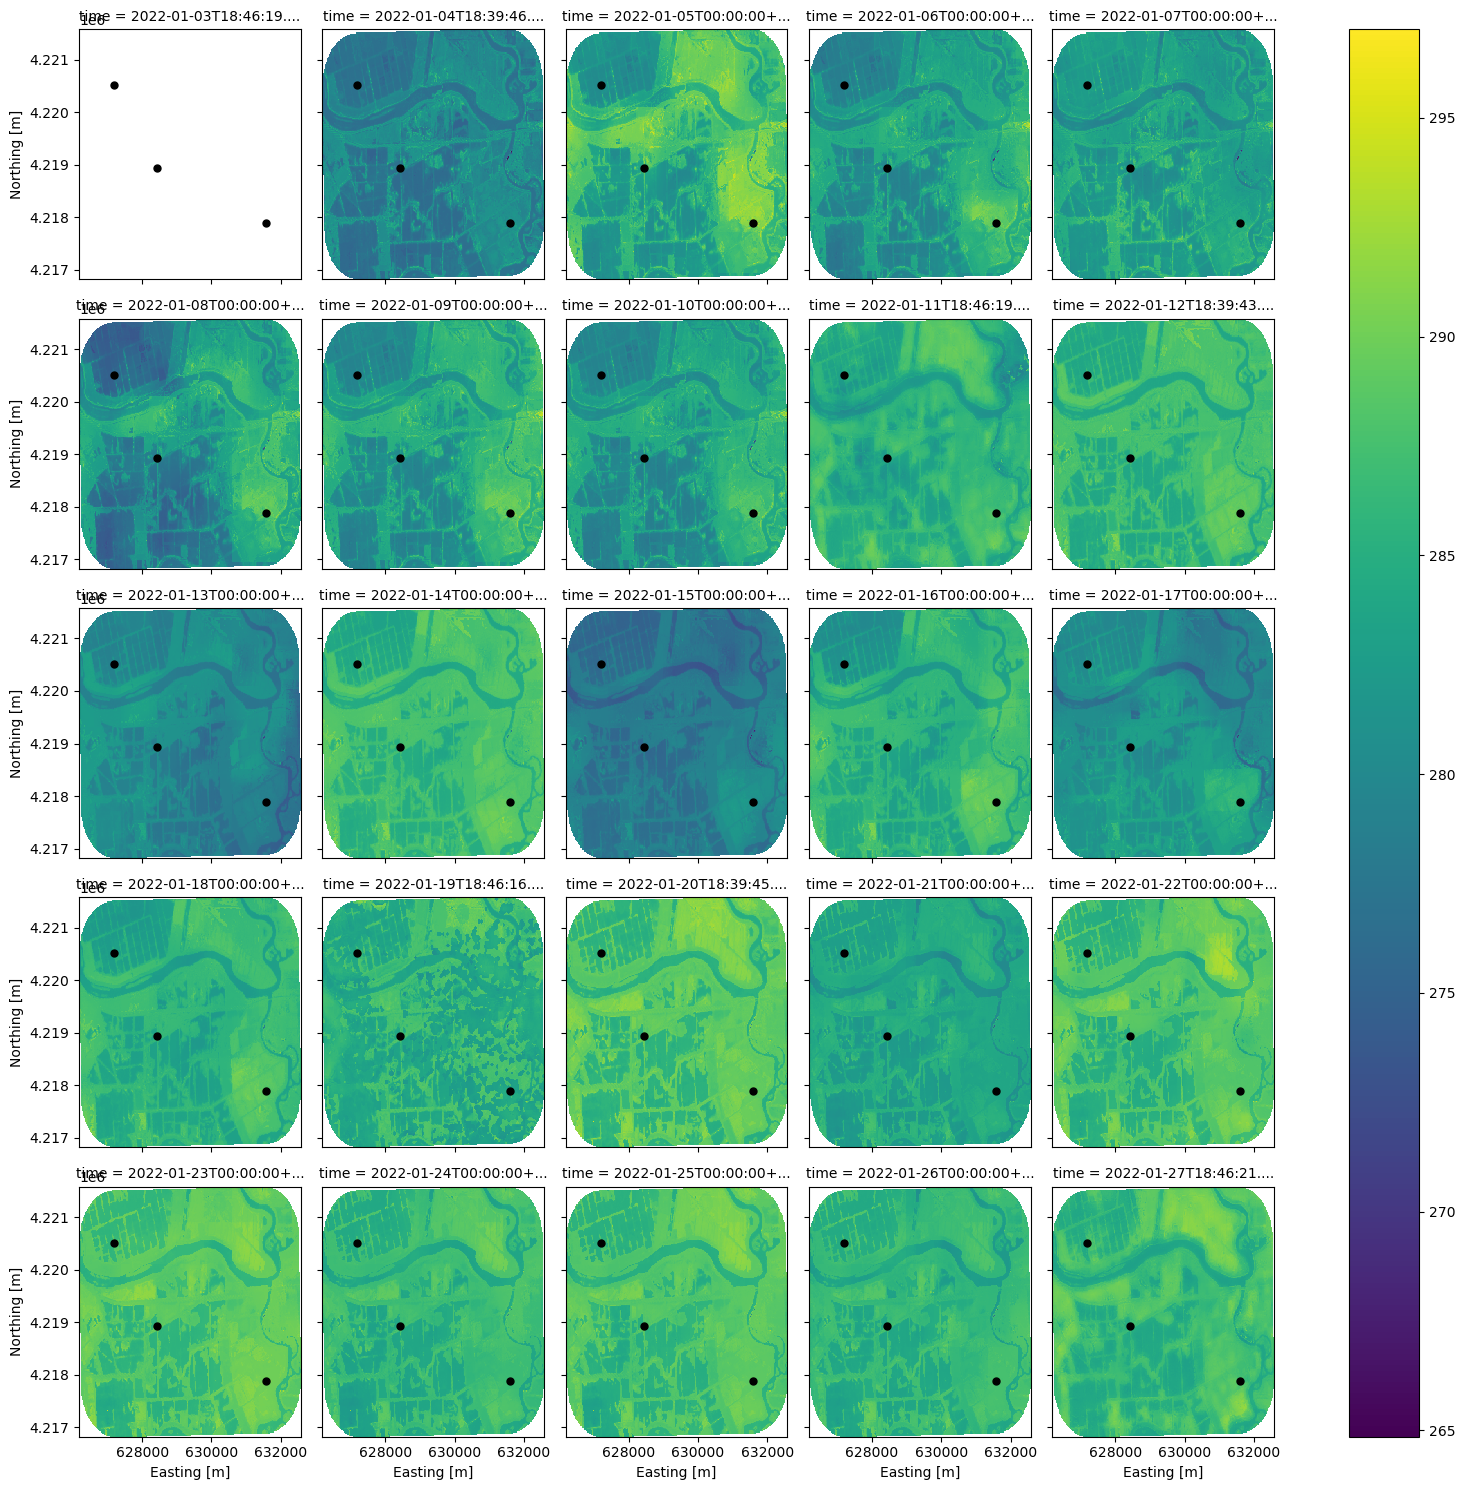

In [11]:
ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
for _, row in insitu_gdf.to_crs(raster_crs).iterrows():
   ax.map(lambda: plt.plot(row.geometry.x, row.geometry.y, markersize=10, marker=".", color="k")) 
plt.show()

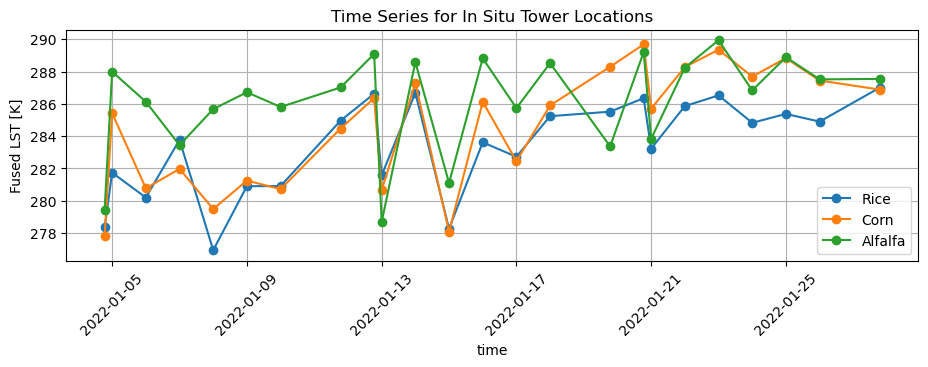

In [17]:
fig, ax = plt.subplots(figsize=(11,3))
for idx, row in insitu_gdf.to_crs(raster_crs).iterrows():
   ax = (ds_clip
         .isel(band=0)
         .sel(x=row.geometry.x, y=row.geometry.y, 
              method='nearest', tolerance=20)
         .plot(marker='o', label=idx))
plt.title(f'Time Series for In Situ Tower Locations')
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.legend()
plt.show()